## Load map and trajectory image

{'image': 'sala06.pgm', 'resolution': 0.05, 'origin': [-9.976213, -9.355639, 0.0], 'negate': 0, 'occupied_thresh': 0.65, 'free_thresh': 0.196}


/home/marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


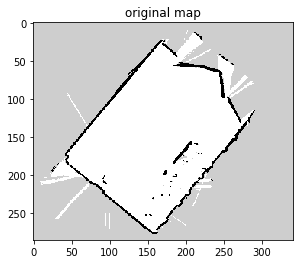

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from yaml import load, dump
import skimage
from os.path import join
import numpy as np
from skimage.morphology import skeletonize

MAPS_dir = '/home/marcel/map_data/s6_6grudnia/maps/set_v3'
MAP_name = 'sala06'
TRAJECTORY_file = MAP_name + '_trajectory.pgm'


trajectory_file = join(MAPS_dir, TRAJECTORY_file)
with open(join(MAPS_dir, MAP_name+'.yaml'), 'r') as f:
    map_meta = load(f)

print(map_meta)

map_img = mpimg.imread(join(MAPS_dir, map_meta['image']))
trajectory_img = mpimg.imread(join(MAPS_dir,TRAJECTORY_file))

plt.imshow(map_img, cmap='gray')
plt.title('original map')
plt.show()

## Process trajectory image

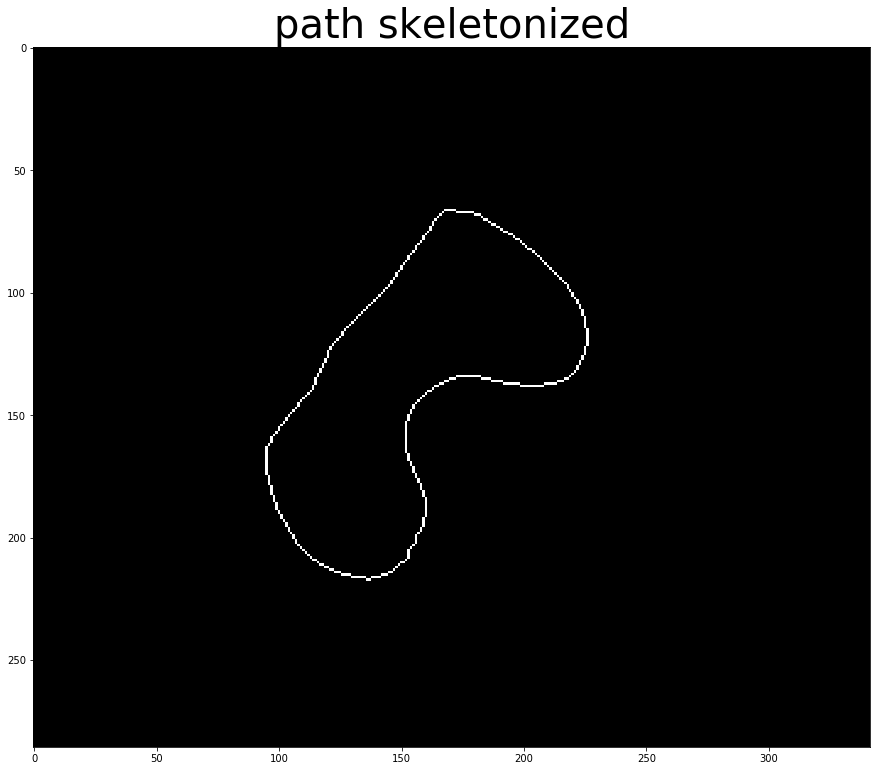

In [71]:
occupied = np.zeros_like(trajectory_img)
free     = np.zeros_like(trajectory_img)
path = np.zeros_like(trajectory_img)

occupied[trajectory_img > map_meta['occupied_thresh']] = 1.0
free[trajectory_img < map_meta['free_thresh']] = 1.0

B = np.argwhere(occupied | free)
(ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1

path = free[ystart:ystop, xstart:xstop]

skeleton = skeletonize(path)

plt.figure(figsize=(15, 15))
plt.imshow(skeleton, cmap='gray')
plt.title('path skeletonized', fontsize=40)
plt.show()

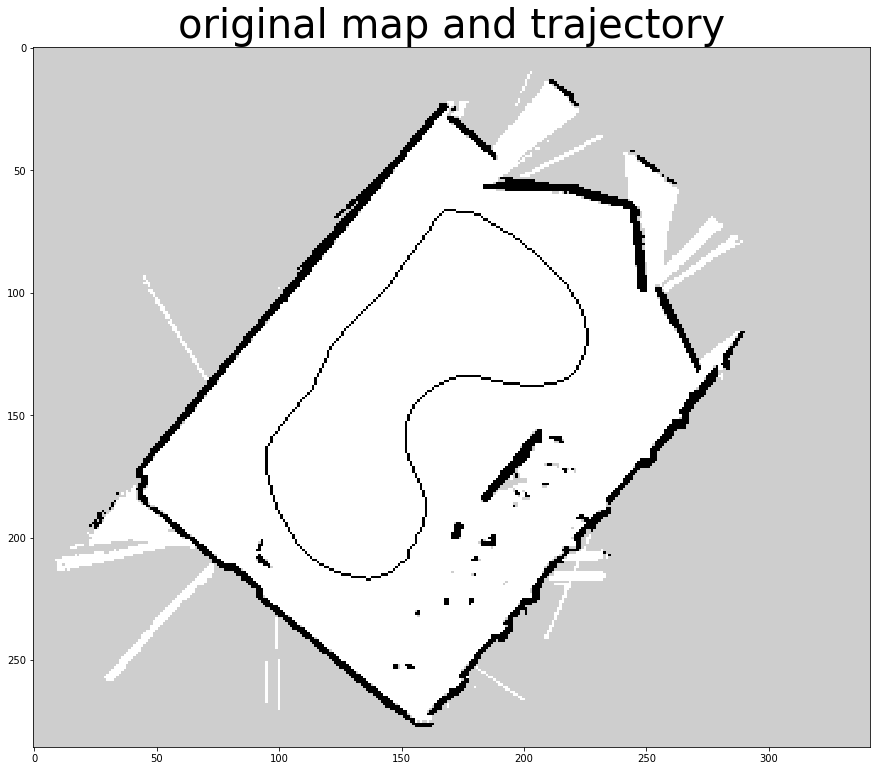

In [77]:
map_combined = np.array(map_img)
map_combined[skeleton==1] = 0
plt.figure(figsize=(15, 15))
plt.imshow(map_combined, cmap='gray')
plt.title('original map and trajectory', fontsize=40)
plt.show()


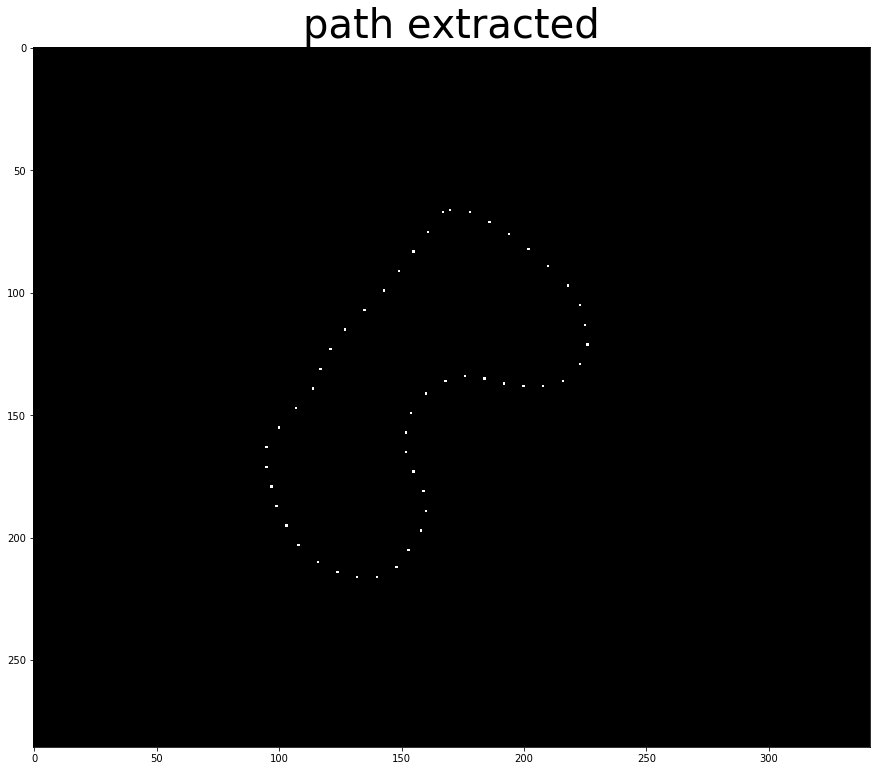

50


In [43]:
from itertools import permutations
import sys
sys.setrecursionlimit(999999999)

OFFSETS = [-1, 0, 1]
NEIGHBORHOOD = [(dy, dx) for dx in OFFSETS for dy in OFFSETS]

available = np.copy(skeleton).astype(np.bool)

def dfs(point, target, available, path, remaining_steps=15):
    x = point[0]
    y = point[1]
    
    if (remaining_steps == 0) and (point == target).all(): return True
    
    # Lower & upper bounds
    if x < 0 or x >= available.shape[1]: return False
    if y < 0 or y >= available.shape[0]: return False
    
    if not available[y, x]: return False
    
    remaining_steps = max(0, remaining_steps-1)
    
    available[y, x] = False
    path.append(point)
    
    for dx, dy in NEIGHBORHOOD:
        child_x = x + dx
        child_y = y + dy
        
        if dfs((child_x, child_y), target, available, path, remaining_steps):
            return True

    path.pop()
    return False

starting_points = np.transpose(np.nonzero(available))
for starting_point in starting_points:
    path = []
    
    if dfs(starting_point[::-1], starting_point[::-1], available, path):
        break

path = path[::-8]        
    
path_img = np.zeros_like(skeleton)
#path_img = skeleton

for point in path:
    path_img[point[1], point[0]] = 1

plt.figure(figsize=(15, 15))
plt.imshow(path_img, cmap='gray')
plt.title('path extracted', fontsize=40)
plt.show()

print(len(path))

## Save results to file

In [34]:
import pickle

data = {}

res = map_meta['resolution']

data['resolution'] = res
data['origin'] = [
    map_meta['origin'][0] + xstart * res,
    map_meta['origin'][1] + (map_img.shape[0] - ystop - 1) * res
]
data['pathpoints'] = [
    (data['origin'][0] + x*res, data['origin'][1] + (path_img.shape[0] - y - 1)*res)
    for x, y in path
]

with open(map_name+'.pkl', 'wb') as f:
    pickle.dump(data, f, 2)